# Game Recommender System to product
---

After an in depth EDA and data cleaning, we're finally at our last step of creating a recommender system. I will first perform SVD to reduce the dimensionality of my final game data this will increase the computational more efficiency. Then I will calculate the cosine similarity of each games of another, this will return as an array of values from -1 to 1. Lastly,I will create a search function that will search the game and return the top 20 most similar games along with the direct link to the game website.

### Table of Contents:

 1. [Performing SVD](#Singular-Value-Decomposition-(SVD))
 2. [Calculate Cosine Similarity](#Cosine-Similarity)
 3. [Search Function](#Creating-a-search-function)
 ---

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy import sparse

%matplotlib inline

## Import DataFrame 

In [2]:
game_lookup = pd.read_csv('./datas/game_lookup.csv', index_col='game_id')

In [3]:
game_lookup.shape

(11557, 2)

I will sort the index (which is the game_id) from lowest to highest; this is to easier interpret the search function later.

In [4]:
game_lookup.sort_index(inplace=True)

#### import the columns and index `csv` that I saved. Assigned into an array to merge into my game_final

Because the game_final data is too large, if I saved it as a CSV it will take ages to save and load. Therefore; I separately saved out the columns and index to `csv`. Then save the DataFrame to `npz` files; then assigned the columns and index back.

In [5]:
columns = pd.read_csv('./datas/game_final_cols.csv', header = None)
cols = np.array(columns[1])
index = pd.read_csv('./datas/game_final_insdex.csv', header= None)
ind = np.array(index[1])

In [6]:
game_final_coo = sparse.load_npz('./datas/game_final_coo.npz')

game_final = pd.SparseDataFrame(game_final_coo, columns = cols, index=ind)



In [7]:
game_final.head()

,abandon,abandoned,abducted,abilities,ability,able,aboard,abomination,abound,absolute,...,Multi-player,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Violent,VR Support
10,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.116701,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Singular Value Decomposition (SVD)

I will perform a SVD. SVD will reduce the dimensionality of my data, also known as singular value decomposition, it's really similar to PCA. the reason why I perform SVD is because it will be more computationally more efficient. Although SVD will reduce my data's dimensionality, but I won't lose any data, it creates new features.  

In [8]:
SVD = TruncatedSVD(n_components=20)
svd_matrix = SVD.fit_transform(game_final)
svd_matrix.shape

(11557, 20)

I will create a variance graph on my SVD matrix. This can visually explain the percentage of the explained variance over my data. After trying with several n_components, 20 is the best fit in terms of explain my data.

In [9]:
def plot_explained_variance(svd_object, n_components):
    fig = plt.figure(figsize=(20,15))
    plt.bar(np.array(range(n_components))+1, 
            svd_object.explained_variance_ratio_, 
            color='g', 
            label='explained variance')
    plt.plot(np.array(range(n_components))+1, 
             np.cumsum(svd_object.explained_variance_ratio_), 
             label='cumulative explained variance')
    plt.legend()
    plt.xlabel('component')
    plt.ylabel('variance ratio')

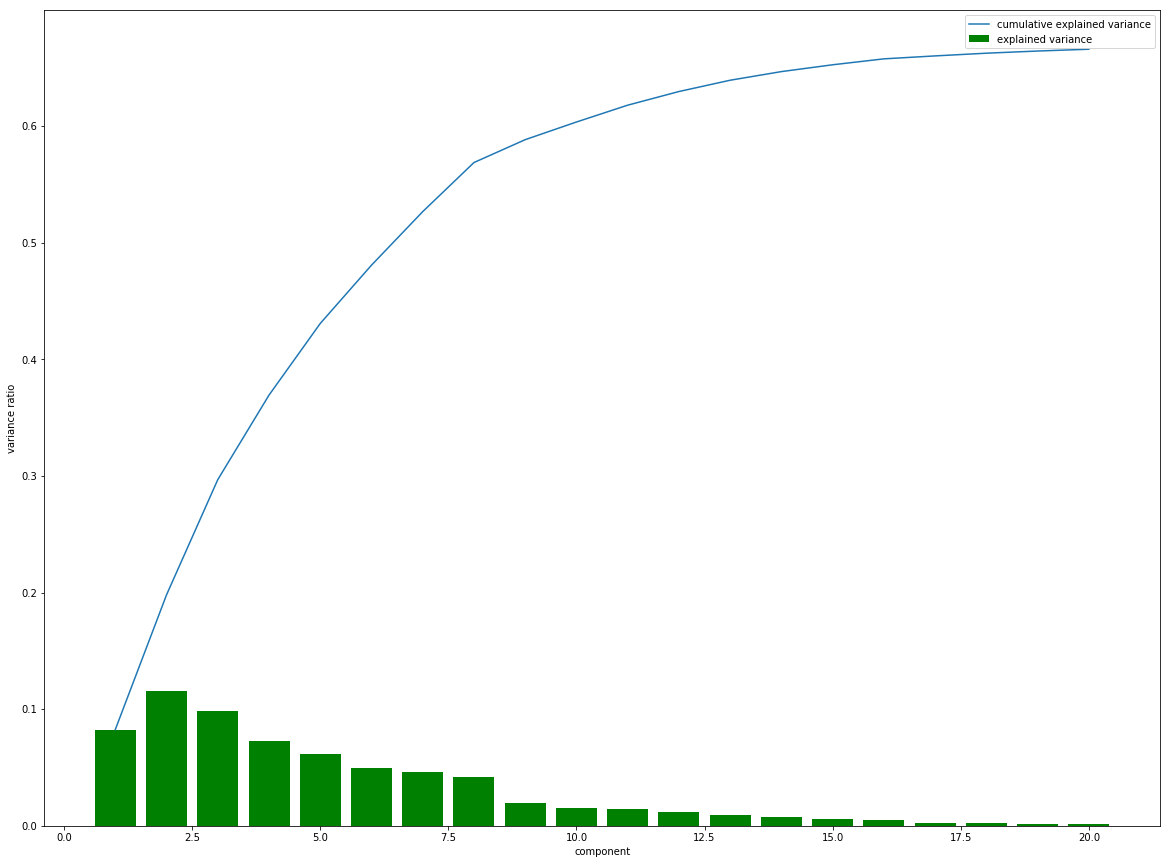

In [10]:
plot_explained_variance(SVD, 20)

**What is this graph?**

the cumulative explained variance curve on the above graph means that it will cover approximately 65% of my data after SVD (dimension reduction). Which have 20 component, in this case, each component will give me a weight of a feature.

## Cosine Similarity


Input my data that performed SVD input Cosine similarity Matrix. Cosine Similarity method takes my case a vector array, then the cosine of each component are computed. From Sklearn definition: Compute cosine similarity between samples in X and Y. Cosine similarity, or the cosine kernel, computes similarity as the normalized dot product of X and Y:

Cosine Similarity will produce result from -1 to 1. Where 1 mean this two games are extremely alike, -1 are the opposite, 0 means the two games are neutral.

In [11]:
cos_sim_mat = cosine_similarity(svd_matrix, svd_matrix)
cos_sim_mat.shape

(11557, 11557)

After getting the cosine similarity for my games. I will need to create a search function that can search by the game title. So the similarity is giving me back the unique game_id. I will need to pair that with the game title that is the game_id. So I will create a dictionary that will have the name of the game as key and assigned a number as the value.

Creating a dict of unique game_id as the key and the title of the game as the value. So when search by the game_id, the name of the game will return.

In [12]:
game_id_title = dict(zip(game_lookup.index, game_lookup['title']))

In [13]:
game_id_title[10]

'Counter Strike'

Creating a dict of index number as key and unique game_id as the value, if a number is input (as long the number is within the range of my dataset) this will return the unique game_id

In [14]:
game_index_title  = dict(zip(range(len(svd_matrix)), game_final.index))

In [15]:
game_index_title[0]

10

If I input a game name it will return a index number of that specific game

In [16]:
game_search_dict = dict(zip([game_id_title[game_index_title[x]] for x in game_index_title], game_index_title))

In [17]:
game_search_dict['Counter Strike']

0

# Creating a search function
---

I will create a search function that doesn't require user to input the full name of the game and it will search the series or any game contain that input. For example: FINAL FANTASY have a lot of different series. If user input that only. I will give you all the final fantasy series along with the recommended games and website to visit.

In [18]:
def game_recommender(game_name):
    try:
        for i in game_lookup[game_lookup['title'].str.contains(game_name)]['title'].values:
            output_gameid = game_search_dict[i]
            sim_dist = (cos_sim_mat[output_gameid]) 
            final = pd.DataFrame(list(zip(game_lookup.title.tolist(), sim_dist)), columns= ['game_name', 'sim_score'])
            final.sort_values('sim_score', ascending=False, inplace=True)
            final['game_website'] = ['https://store.steampowered.com/app/'+str(game_index_title[x]) for x in final.index]
            print(f'Game Name: '+str(i))
            print(final[1:20])
            print(' ')
            print('----------------------------------------------------------------------------------------------------------')
    except:
        print('Oops! No result were found, Please check your spelling and try again!')


Team Fortress 2 is a first person cartoon style shooting game. Based on the result below, where I create a direct link to the specific game website at steam.

- Dirty Bomb: Dirty Bomb is a first person cartoon style shooting game. That offer in different classes/characters. It's a multi-player game. 
- Gotham City Impostors: This is a Batman series based, cartoon style first person action game. This is a multi-player game.
- America's Army : This is a realistic, first person action shooter that is also multi-player game.

Based on above three games; we can clearly see the similar features that each game has. I personally played all those game before. This is a really good recommender. The reviews of the game is really good to that specific game as well. 

In [19]:
game_recommender('Team Fortress 2')

Game Name: Team Fortress 2
                                game_name  sim_score  \
3622                           Dirty Bomb   0.999859   
1187  Gotham City Impostors: Free To Play   0.999603   
1130      America's Army: Proving Grounds   0.999402   
1529                             Warframe   0.999295   
459                                 BRINK   0.999275   
6160                             Paladins   0.999187   
25       Counter Strike: Global Offensive   0.999024   
5086                              WARMODE   0.998768   
4958                                SMITE   0.998762   
6829                      Hide and Shriek   0.998630   
4242            Rumble Fighter: Unleashed   0.998494   
3726                                Batla   0.997867   
8572                          Switchblade   0.997848   
378                        Tribes: Ascend   0.997609   
8958                      Quake Champions   0.996512   
7246                           Battlerite   0.994850   
2326                 

I will search a game called "Final Fantasy". This is a RPG game that is single player or multi-player depends on the series. Based on the search function I created, if Final Fantasy is entered. It will returned all the game that have final fantasy. Meaning all the series from this game will be search and return with 20 games that are similar to that specific Final Fantasy Series.

In [20]:
game_recommender('FINAL FANTASY V')

Game Name: FINAL FANTASY VII
                                            game_name  sim_score  \
808                   Dragon Age: Origins   Awakening   0.999902   
6958      The Elder Scrolls V: Skyrim Special Edition   0.999884   
9067                                Elminage ORIGINAL   0.999850   
718                             Risen 2   Dark Waters   0.999831   
10221  Achievement Lurker: Respectable Accomplishment   0.999822   
8025                                         ATOM RPG   0.999801   
6222                                          7 Mages   0.999801   
2685                               FINAL FANTASY XIII   0.999783   
4697            The Deep Paths: Labyrinth Of Andokost   0.999782   
5801                           The Gate of Firmament    0.999763   
9277                                Nights of Azure 2   0.999744   
314                                       Overlord II   0.999717   
4758                                 FINAL FANTASY IX   0.999712   
7588               